## Prorcessing the Labels of the Raw IMDB Data

In [1]:
import os 

In [2]:
imdb_dir = "/Users/chloequinto/documents/s20/cs583/ch6/aclImdb"
train_dir = os.path.join(imdb_dir, 'train') #add train after 
print(train_dir)

/Users/chloequinto/documents/s20/cs583/ch6/aclImdb/train


In [3]:
labels = []
texts = []

for label_type in ['neg/', 'pos/']: 
    dir_name = os.path.join(train_dir, label_type)
    print(dir_name)
    for fname in os.listdir(dir_name): 
        if fname[-4:] == '.txt': 
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == "neg": 
                labels.append(0)
            else: 
                labels.append(1)

/Users/chloequinto/documents/s20/cs583/ch6/aclImdb/train/neg/
/Users/chloequinto/documents/s20/cs583/ch6/aclImdb/train/pos/


In [4]:
# Let's look at the labels 
labels[:20]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [5]:
texts[:4]

["Working with one of the best Shakespeare sources, this film manages to be creditable to it's source, whilst still appealing to a wider audience.<br /><br />Branagh steals the film from under Fishburne's nose, and there's a talented cast on good form.",
 'Well...tremors I, the original started off in 1990 and i found the movie quite enjoyable to watch. however, they proceeded to make tremors II and III. Trust me, those movies started going downhill right after they finished the first one, i mean, ass blasters??? Now, only God himself is capable of answering the question "why in Gods name would they create another one of these dumpster dives of a movie?" Tremors IV cannot be considered a bad movie, in fact it cannot be even considered an epitome of a bad movie, for it lives up to more than that. As i attempted to sit though it, i noticed that my eyes started to bleed, and i hoped profusely that the little girl from the ring would crawl through the TV and kill me. did they really think 

## Tokenizing the text of the raw IMDB data

In [6]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences 
import numpy as np
 
    
maxlen = 100 # cuts off reviews after 100 words 
training_samples = 200 #trains on 200 samples 
validation_samples = 10000 # validations on 10,000 samples 
max_words = 10000

Using TensorFlow backend.
/usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/py

In [7]:
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(texts) 
sequences = tokenizer.texts_to_sequences(texts) 
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 88582 unique tokens.


In [8]:
data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of Data Tensor:', data.shape)
print('Shape of Label Tensor: ', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

Shape of Data Tensor: (25000, 100)
Shape of Label Tensor:  (25000,)


In [9]:
x_train = data[:training_samples]
y_train = labels[:training_samples]

x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

In [10]:
y_val

array([1, 1, 1, ..., 1, 1, 1])

## Parsing the GloVe Word-Embeddings File 

In [11]:
glove_dir = "/Users/chloequinto/documents/s20/cs583/ch6/glove.6B"

In [12]:
embeddings_index = {}
f = open(os.path.join(glove_dir, "glove.6B.100d.txt"))
for line in f: 
    values = line.split()
#     print(values)
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs 
f.close()

print("Found %s word vectors. " % len(embeddings_index))

Found 400000 word vectors. 


Next, you'll build an embedding matrix that you can load into an Embedding layer. It must be a matrix of shape (max_words, embeddings_dim) 

## Preparing the GloVE word-embeddings matrix 

In [13]:
embedding_dim = 100 
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items(): 
    if i < max_words: 
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector # words not found in embedding index will be all zereos 

## Model Definition 

In [14]:
from keras.models import Sequential 
from keras.layers import Embedding, Flatten, Dense 

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length = maxlen))
model.add(Flatten()) #takes the grid and puts it into a vector so we can backprop from FC layers 
model.add(Dense(32, activation='relu')) #32
model.add(Dense(1, activation='sigmoid')) # one class 
model.summary()


Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


## Loading the pretrained word embeddings into the Embedding Layer


In [15]:
model.layers[0].set_weights([embedding_matrix])

In [16]:
model.layers[0].trainable = False  #freeze layers 

Additionally, you'll freeze the Embedding layer (set its trainable attribute to False), following the same rationale you're already familiar with in the context of pretrained convnet features. When aprts of a model arre pretrained (like your embeddings layer) and parts are randly initialized (like your classifier) the pretrained parts shouldn't be updated during training to ***avoid forgetting what they already know***

## Training and Evaluation 

In [17]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [18]:
history = model.fit(x_train, y_train, epochs = 10, batch_size = 32, validation_data=(x_val, y_val))

Instructions for updating:
Use tf.cast instead.
Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0774 - acc: 0.9900 - val_loss: 1.7536e-05 - val_acc: 1.0000
Epoch 2/10
200/200 [==============================] - 0s 2ms/step - loss: 7.7821e-05 - acc: 1.0000 - val_loss: 1.6254e-05 - val_acc: 1.0000
Epoch 3/10
200/200 [==============================] - 0s 2ms/step - loss: 5.1463e-05 - acc: 1.0000 - val_loss: 1.4916e-05 - val_acc: 1.0000
Epoch 4/10
200/200 [==============================] - 0s 2ms/step - loss: 3.1883e-05 - acc: 1.0000 - val_loss: 1.3849e-05 - val_acc: 1.0000
Epoch 5/10
200/200 [==============================] - 0s 2ms/step - loss: 2.1104e-05 - acc: 1.0000 - val_loss: 1.3019e-05 - val_acc: 1.0000
Epoch 6/10
200/200 [==============================] - 0s 2ms/step - loss: 1.5376e-05 - acc: 1.0000 - val_loss: 1.2253e-05 - val_acc: 1.0000
Epoch 7/10
200/200 [==============================] - 0s 2ms/step - 

In [19]:
model.save_weights('pre_trained_glove_model.h5')

## Plotting the Results 

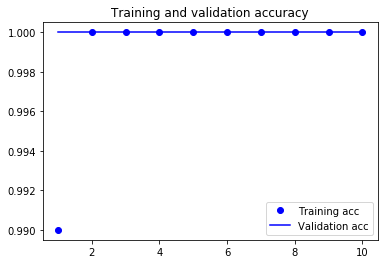

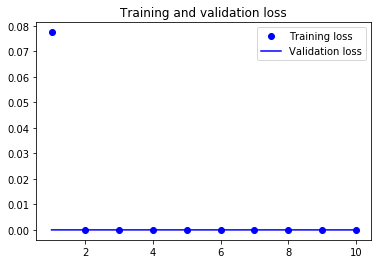

In [20]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Without pretrained model 

In [21]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 3ms/step - loss: 0.4588 - acc: 0.9350 - val_loss: 0.0994 - val_acc: 1.0000
Epoch 2/10
200/200 [==============================] - 0s 2ms/s

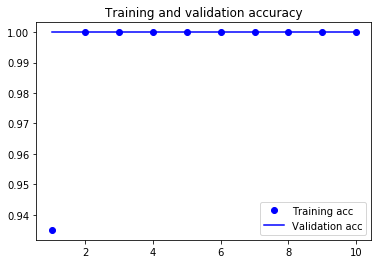

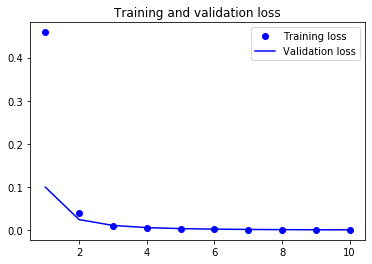

In [22]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Summary
- Now you're able to turn raw text into something a neural network can understand 
- Use the embedding layer in a Keras model to learn task-specific token embeddings 
- Use pretrained word embeddings to get an extra boost on small natural-language-processing problems